# Computational User Interface Design 2021

## Bayesian Optimization

[Original slides from a lecture at Aalto by Tomi Peltola](http://www.tmpl.fi/bayesian-optimization/slides.Rmd)

---
### Yi-Chi Liao

Ph.D. candidate at User Interfaces (http://yichiliao.com).

<div class="center">
<img src="imgs/3dtouch.png" style="width: 90%" />
</div>

Using multi-objective Bayesian optimization to optimize the 3D transfer function design.

<div class="center">
<img src="imgs/button.png" style="width: 90%" />
</div>
Using multi-objective Bayesian optimization to optimize a touch button design.


## Participants wanted!!

- Possible dates: Wed (24th) - Fri (26th) / next Mon (29th) - next Wed (Dec 1st).
- Duration: 2 - 3 hours.
- Reward: 30 euro Fat Lizard Coupon.
- Task: assist the designer to derive the optimal designs.
- Ping me if you're interested! (yi-chi.liao@aalto.fi / telegram: hciresearch)


## Learning goal

This is practically oriented lecture for HCI researchers and practitioners. After this lecture and the exercises, you should

 1. understand the basics of Bayes Theorem,
 2. understand the basics of Bayesian optimization and its applications in HCI,
 2. be able to assess when it can be a useful tool and when not,
 3. know how to use the GPyOpt Python package for your own applications.


## Table of contents

 1. Introduction
 2. Bayes Theorem
 2. Bernoulli bandit
 3. Bayesian optimization 
 4. Acquisition functions
 5. Application example
 6. Conclusion

---
# 1. Introduction

<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Ask your friend to pick one favorite color. You would like to figure out what they are, **but** you can only ask about one color at a time. When asked about a color, the friend must tell how liked it is on a scale from 1 to 5 (best). If you only have 8 questions, **how** should you choose which color to ask?</div>
</p>

<div class="center">
<img src="imgs/color_platte.png" style="width: 90%" />
</div>


## Overview 
Bayesian optimization is a modern approach to **global optimization**. It is robust and sample-efficient and well-suited for noisy, expensive evaluative functions. It uses a **surrogate model** for approximating the model fit across the parameter space.  Posteriori probability provides an intuitive quantification of acquired knowledge of the best parameter values given the available observation data. Another core idea is to use an **acquisition rule** for selecting which parameter values are used for generating predictions, based on the surrogate model. Inference is performed through a sequence of optimization rounds. 

Recipe:

- At the beginning of each round, the acquisition rule is used to select a set of parameter values that will be used to generate predictions. The locations are balanced such that they cover both unknown regions of the parameter space (**exploration**) and regions with high probability to lead to good model fit (**exploitation**). 
- After predictions have been generated at each location, the surrogate model is updated based on the observed model fits, and the next optimization round begins. 
- The final parameter estimates are often chosen to be the parameter values that lead to best predicted model fit on average.

[Visual overview](imgs/bo-overview.png).
Source: https://towardsdatascience.com

**Compare: Grid search** assumes that the optimal parameter values are contained within some bounded region of the parameter space. Then divide this bounded parameter space into a large number of smaller cells, often by using an even grid. Then, for each grid cell, a dataset is generated using the parameter values at the cell, and finally the parameter values that yielded the best model fit are used as the final estimate.

## Problem

Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**How would you solve this?**

 * Hand-tuning / trial and error,
 * random search,
 * grid search,
 * gradient descend,
 * evolutationary algorithms,
 * different types of programming (linear, integer, etc.),
 * ...

The above solutions require different levels of assumptions (except for the evolutionary algorithms). Some assume the human has the ability to solve the problem, some assume the evaluation of the function is free and fast, some assume there is a gradient, etc. Bayesian optimization requires no such assumptions. It is a model-free, gradient-free solution.

## Application - A/B testing

But what if... $f$ 

 * can only be evaluated implicitly,
 * with a lot of noise, and
 * is costly to evaluate.
 
For example, optimize for click-through rate, retention time, or purchases, implicitly measuring user satisfaction, interest, or revenue of different version of a web site.

By choosing conditions wisely, Bayesian optimization can converge to a good design quicker and avoid contaminating users with potentially bad designs.

## Application - Computational design

But what if ... $f$ 

 * is a black-box (e.g., contains human judgement),
 * with noisy and expensive/slow evaluations,
 * and multi-modal.

For example, optimizing parameters for procedural animation generation by asking humans to rate generated examples.

<div class="center">
<img src="imgs/anim.png" style="width: 50%" />
</div>

<div style="font-size: 10px;"><a href="https://dl.acm.org/citation.cfm?id=1921443">[image: Brochu et al., 2010]</a></div>

## Application - Adaptive interfaces

But what if ... $f$ 

 * is based on an implicit signal from human,
 * with noisy and expensive/slow evaluations.

For example, optimizing step rate to minimize metabolic cost.

<div class="center">
<img src="imgs/wearable_devices.png" style="width: 70%" />
</div>

<div style="font-size: 10px;"><a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184054">[image: Kim et al., 2017]</a></div>


## Application - Inverse modeling

But what if ... $f$ 

 * contains a parametric simulator,
 * with noisy and expensive/slow evaluations.

For example, fitting parameters of cognitive simulators to experimental data.

<div class="center">
<img src="imgs/abc2.png" style="width: 60%" />
</div>

<div style="font-size: 10px;"><a href="https://dl.acm.org/citation.cfm?doid=3025453.3025576">[image: Kangasraasio et al., 2017]</a></div>


## Application - Others

 * Recommender systems
 * Sensor networks
 * AutoML: automatic tuning of machine learning models
 * Robotics and reinforcement learning

## The computational problem

**Problem:** Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**Challenges**
 * $f$ is a black-box that we can only evaluate point-wise, 
 * $f$ can be multi-modal,
 * $f$ is slow or expensive to evaluate,
 * evaluations of $f$ are noisy,
 * $f$ has no gradients available (can be used if available).

** Basic idea of BO **

We want to find the minimum with small number of evaluations of $f$. Solution:

 1. Construct a tractable **statistical surrogate model** of $f$.
 2. Turn the optimization problem into **a sequence of easier problems**.

# 2. Bayes Theorem and Bayesian Inference<a id="2">

We have established a general understanding of Bayes Theorem and Bayesian inference in order to understand the core elements of Bayesian optimization.

## 2.1 Conditional and  Joint Probability <a id="21">

### Joint Probability

$P(A,B)$ is the probability two events $A$ and $B$ _both_ occurring.
* For example, getting two heads in a row.

If $A$ and $B$ are independent, then $P(A,B)=P(A)P(B)$ but be warned: this is not always (or often) the case.

One way to think of this is considering "AND" as multiplication: the probability of A **and** B is the probability of A **multiplied** by the probability of B (if they are independent!).

#### Hands-On: Joint Probability and Coin Flipping

Verify that $P(A,B)=P(A)P(B)$ in the two fair coin-flip case (A=heads, B=heads) by 
- first simulating two coins being flipped together and calculating the proportion of occurences with two heads;
- then simulating one coin flip and calculating the proportion of heads and then doing that again and multiplying the two proportions.

Your two calculations should give "pretty close" results and not the same results due to the (in)accuracy of simulation. 

0.2525


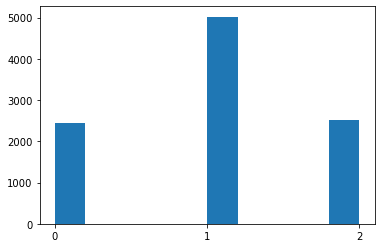

In [30]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

# Hands-on: try to change the possibility of getting a head (1) and see what will happen
x_0 = np.random.binomial(2, 0.5, 10000)
p_ab = sum(x_0==2)/len(x_0)

# Now, plot the histogram of the results
fig, ax = plt.subplots()
ax.hist(x_0)
ax.set_xticks([0,1,2])
print(p_ab)

In [4]:
# Solution: Calculate P(A)P(B)
x_1 = np.random.binomial(1, 0.5, 10000)
x_2 = np.random.binomial(1, 0.5, 10000)
p_a = sum(x_1 == 1)/len(x_1)
p_b = sum(x_2 == 1)/len(x_2)
p_a*p_b

0.2465577

### Conditional Probability

Now that we have a grasp on joint probabilities, lets consider conditional probabilities, that is, the probability of some $A$, knowing that some other $B$ is true. We use the notation $P(A|B)$ to denote this.  

Conditional and joint probabilites are related by the following:
$$ P(A,B) = P(A|B)P(B)$$

## 2.2 Bayes Theorem <a id="22">

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

![bayes](./imgs/bayes_theo2.png)

### The cookie problem
There are two bowls of cookies: 
- Bowl #1 has 10 chocolate and 30 vanilla
- Bowl #2 has 20 chocolate and 20 vanilla

You pick a bowl at random, and pick a cookie at random,
the cookie turns out to be vanilla. 


What is the probability that you pick Bowl #1?

`Pmf.from_seq` makes a `Pmf` object from a sequence of values.

Here's how we can use it to create a `Pmf` with two equally likely hypotheses.

In [8]:
from empiricaldist import Pmf

cookie = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
cookie

,probs
Bowl 1,0.5
Bowl 2,0.5


In [9]:
cookie['Bowl 1'] *= 0.75
cookie['Bowl 2'] *= 0.5
cookie.normalize()
cookie

,probs
Bowl 1,0.6
Bowl 2,0.4


### Hands-on: 
    
Suppose we put the first cookie back, stir, choose again from the same bowl, and get a chocolate cookie.  
What are the posterior probabilities after the second cookie?

Hint: The posterior (after the first cookie) becomes the prior (before the second cookie).

In [10]:
# Solution

cookie = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
cookie['Bowl 1'] *= 0.75 * 0.25
cookie['Bowl 2'] *= 0.5 * 0.5
cookie.normalize()
cookie

,probs
Bowl 1,0.428571
Bowl 2,0.571429


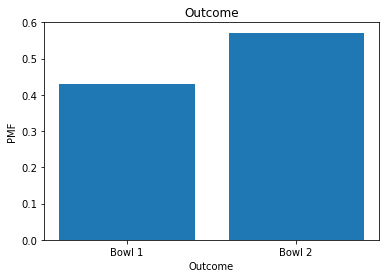

In [11]:
def decorate_cookie(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('PMF')
    plt.title(title)

cookie.bar()
decorate_cookie('Outcome')

### The dice problem

Create a suite of hypotheses that represents dice with different numbers of sides.

In [28]:
# Dice 4 has 4 faces, Dice 6 has 6 faces, ...
dice = Pmf.from_seq([4, 6, 8, 12])
dice

,probs
4,0.25
6,0.25
8,0.25
12,0.25


We'll solve this problem two ways.  First we'll do it "by hand", as we did with the cookie problem; that is, we'll multiply each hypothesis by the likelihood of the data, and then renormalize.

### Hands-on:
In the space below, update `dice` based on the likelihood of the data (rolling a 6), then normalize and display the results.

In [29]:
# Solution

dice[4] *= 0
dice[6] *= 1/6
dice[8] *= 1/8
dice[12] *= 1/12

dice.normalize()
dice

,probs
4,0.000000
6,0.444444
8,0.333333
12,0.222222


### Hands-on:

Now let's do the same calculation using `Pmf.update`, which encodes the structure of a Bayesian update.

Define a function called `likelihood_dice` that takes `data` and `hypo` and returns the probability of the data (the outcome of rolling the die) for a given hypothesis (number of sides on the die).

Hint: What should you do if the outcome exceeds the hypothetical number of sides on the die?

Here's an outline to get you started.

In [12]:
def likelihood_dice(data, hypo):
    """Likelihood function for the dice problem.
    
    data: outcome of the die roll
    hypo: number of sides
    
    returns: float probability
    """
    # TODO: fill this in!
    if data > hypo:
        return 0
    else:
        return 1 / hypo

In [15]:
# Now we can create a Pmf object and update it.

dice = Pmf.from_seq([4, 6, 8, 12])
dice.update(likelihood_dice, 6)
dice

,probs
4,0.000000
6,0.444444
8,0.333333
12,0.222222


### Hands-on:

Create another Pmf object that update three times (got 6, 7, and 8). 

In [16]:
# Solution

dice = Pmf.from_seq([4, 6, 8, 12])
dice.update(likelihood_dice, 6)
dice.update(likelihood_dice, 7)
dice.update(likelihood_dice, 8)
dice

,probs
4,0.000000
6,0.000000
8,0.771429
12,0.228571


### The Euro problem

*"When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  'It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  'If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.' "*

From “The Guardian” quoted by MacKay, *Information Theory, Inference, and Learning Algorithms*.


### Hands-on:
Write a function called `likelihood_euro` that defines the likelihood function for the Euro problem.  Note that `hypo` is in the range 0 to 100.

Here's an outline to get you started.

In [32]:
def likelihood_euro(data, hypo):
    """ Likelihood function for the Euro problem.
    
    data: string, either 'H' or 'T'
    hypo: prob of heads (0-100)
    
    returns: float probability
    """
    # TODO: fill this in!
    x = hypo / 100
    if data == 'H':
        return x
    else:
        return 1-x

In [33]:
def decorate_euro(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of heads')
    plt.ylabel('PMF')
    plt.title(title)

We start from a uniform distribution.

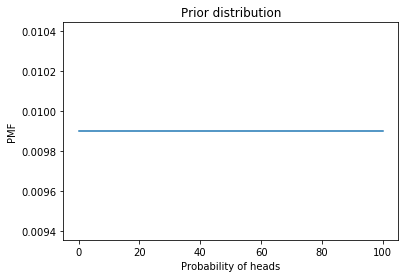

In [34]:
euro = Pmf.from_seq(range(101))
euro.plot()
decorate_euro('Prior distribution')

Now we can update with a single head:

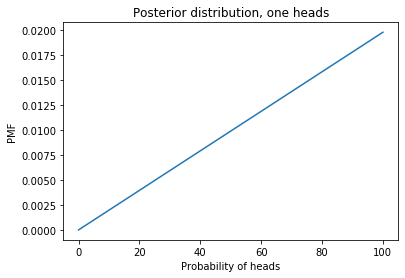

In [35]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, one heads')

Another head:

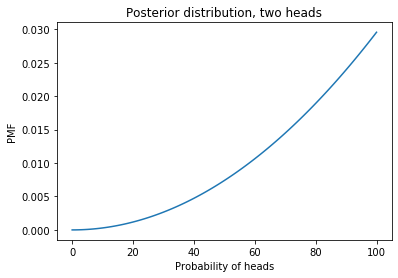

In [36]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, two heads')

And a tail:

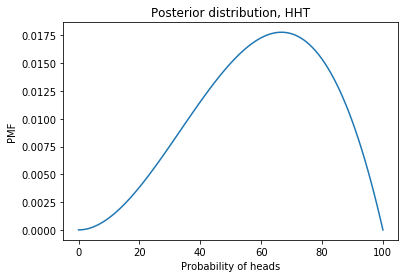

In [37]:
euro.update(likelihood_euro, 'T')
euro.plot()
decorate_euro('Posterior distribution, HHT')

Starting over, here's what it looks like after 4 heads and 2 tails.

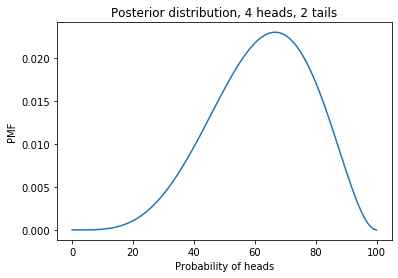

In [38]:
euro = Pmf.from_seq(range(101))

for outcome in 'HHHHTT':
    euro.update(likelihood_euro, outcome)

euro.plot()
decorate_euro('Posterior distribution, 4 heads, 2 tails')

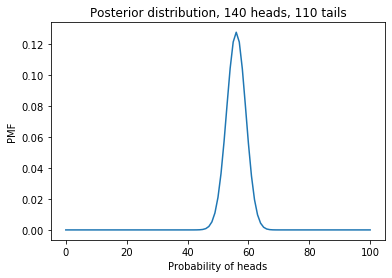

In [39]:
euro = Pmf.from_seq(range(101))

evidence = 'H' * 140 + 'T' * 110
for outcome in evidence:
    euro.update(likelihood_euro, outcome)
    
euro.plot()

decorate_euro('Posterior distribution, 140 heads, 110 tails')

### Swamping the prior

The following function makes a Euro object with a triangle prior.

No handles with labels found to put in legend.


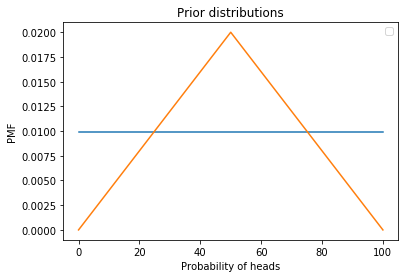

In [40]:
def TrianglePrior():
    """Makes a Suite with a triangular prior.
    """
    suite = Pmf(name='triangle')
    for x in range(0, 51):
        suite[x] = x
    for x in range(51, 101):
        suite[x] = 100-x 
    suite.normalize()
    return suite

euro1 = Pmf.from_seq(range(101), name='uniform')
euro1.plot()

euro2 = TrianglePrior()
euro2.plot()

plt.legend()
decorate_euro('Prior distributions')

### Hands-on
1. Update `euro1` and `euro2` with the same data (4 heads and 2 tails) and plot the posteriors.  How big is the difference in means?

2. Update `euro1` and `euro2` with the same data (40 heads and 20 tails) and plot the posteriors.  How big is the difference in means?

No handles with labels found to put in legend.


(62.499997812718675, 58.604627060579226)

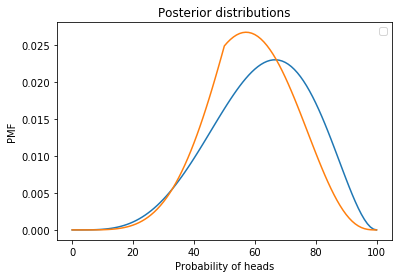

In [41]:
# Solution

evidence = 4 * "H" + 2 * "T"
for outcome in evidence:
    euro1.update(likelihood_euro, outcome)
    euro2.update(likelihood_euro, outcome)

euro1.plot()
euro2.plot()

decorate_euro('Posterior distributions')
plt.legend()

euro1.mean(), euro2.mean()

No handles with labels found to put in legend.


(66.12903225806451, 65.09028453076183)

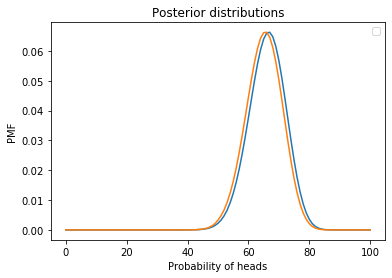

In [42]:
# Solution

euro1 = Pmf.from_seq(range(101), name='uniform')

euro2 = TrianglePrior()


evidence = 40 * "H" + 20 * "T"
for outcome in evidence:
    euro1.update(likelihood_euro, outcome)
    euro2.update(likelihood_euro, outcome)

euro1.plot()
euro2.plot()

decorate_euro('Posterior distributions')
plt.legend()

euro1.mean(), euro2.mean()

## 2.3 From Bayes' Theorem to (Simulated) Bayesian Inference <a id='23'>

Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However, 

1. It doesn't tell us how certain we can be of that estimate and
2. This type of intuition doesn't extend to even slightly more complex examples.

Bayesian inference helps us here. We can calculate the probability of a particular $p=p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.

$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$
  


In this equation, we call $P(p)$ the prior (distribution), $P(D|p)$ the likelihood and $P(p|D)$ the posterior (distribution). The intuition behind the nomenclature is as follows: the prior is the distribution containing our knowledge about $p$ prior to the introduction of the data $D$ & the posterior is the distribution containing our knowledge about $p$ after considering the data $D$.

  
**Note** that we're _overloading_ the term _probability_ here. In fact, we have 3 distinct usages of the word:
- The probability $p$ of seeing a head when flipping a coin;
- The resulting binomial probability distribution $P(D|p)$ of seeing the data $D$, given $p$;
- The prior & posterior probability distributions of $p$, encoding our _uncertainty_ about the value of $p$.

**Key concept:** We only need to know the posterior distribution $P(p|D)$ up to multiplication by a constant at the moment: this is because we really only care about the values of $P(p|D)$ relative to each other – for example, what is the most likely value of $p$? To answer such questions, we only need to know what $P(p|D)$ is proportional to, as a function of $p$. Thus we don’t currently need to worry about the term $P(D)$. In fact,

$$P(p|D) \propto P(D|p)P(p) $$

**Note:** What is the prior? Really, what do we know about $p$ before we see any data? Well, as it is a probability, we know that $0\leq p \leq1$. If we haven’t flipped any coins yet, we don’t know much else: so it seems logical that all values of $p$ within this interval are equally likely, i.e., $P(p)=1$, for $0\leq p \leq1$. This is known as an uninformative prior because it contains little information (there are other uninformative priors we may use in this situation, such as the Jeffreys prior, to be discussed later). People who like to hate on Bayesian inference tend to claim that the need to choose a prior makes Bayesian methods somewhat arbitrary, but as we’ll now see, if you have enough data, the likelihood dominates over the prior and the latter doesn’t matter so much.

---

# 3. Multi-armed bandit (Bernoulli bandit)

*To link Bayesian optimization to Bayesian statistics, we look at a simpler, so-called bandit problem first.*

<div class="center">
<img src="imgs/multi_armed_bandit.png" style="width: 80%" />
</div>

Illustration of a multi-armed bandit.

<div class="center">
<img src="imgs/2_armed_bandit.png" style="width: 80%" />
</div>

Illustration of a two-armed bandit.

**Task**: Conduct an A/B test to find which of two versions of a Web ad is better; that is, which ad gets most clicks.


Problem setting:
 * **Experiment**: Show one of the two versions to a visitor.
 * **Observation**: Did the visitor click the ad.
 
Minimize *regret* $R$ for $T$ experiments:
$$R = T \E[y^*] - \sum_{t=1}^T y_t$$
 * $\E[y^*]$ is the expected click rate for the better ad,
 * $y_t \in \{0,1\}$ is whether visitor $t$, who was shown version $x_t \in \{A, B\}$, clicked the ad.

 * Model click rates of $A$ and $B$ are $\rho_A$ and $\rho_B$, which are independent. Equations for A below.
 
**Bayes theorem**: $p(\theta \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid \theta)}{p(\mathcal{D})}  p(\theta)$

updates **prior** knowledge $p(\theta)$ with **observations (likelihood)** $\mathcal{D}$ to **posterior** knowledge $p(\theta \mid \mathcal{D})$.

Observation (likelihood) model:

$$\Pr(y_t \mid x_t = A) = \textrm{Bernoulli}(y_t \mid \rho_A) = \rho_A^{y_t} (1 - \rho_A)^{1-y_t}.$$

Prior model:

$$p(\rho_A) = \textrm{Beta}(\rho_A \mid \alpha, \beta) = \frac{1}{B(\alpha, \beta)} \rho_A^{\alpha-1} (1 - \rho_A)^{\beta-1}.$$


Given a dataset of $t$ observations $\mathcal{D}_t = \{(x_1, y_1), \ldots, (x_t, y_t)\}$, the posterior distribution is
$$p(\rho_A \mid \mathcal{D}_t) = \frac{p(\rho_A) \prod_{t: x_t = A} \Pr(y_t \mid x_t = A)}{\int_0^1 p(\rho_A) \prod_{t: x_t = A} \Pr(y_t \mid x_t = A) d\rho_A} = \textrm{Beta}(\rho_B \mid \alpha + n^{A}_1, \beta + n^{A}_0),$$
where $n^{A}_1$ and $n^{A}_0$ are the total numbers of $y_t = 1$ and $y_t = 0$ for $x_t = A$.



### Extended reading:
- What is Beta distribution: https://en.wikipedia.org/wiki/Beta_distribution
- Interactive Beta distribution: https://keisan.casio.com/exec/system/1180573226
- What is Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

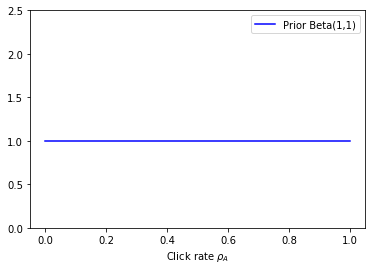

In [43]:
x = np.linspace(0, 1, 101)

plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

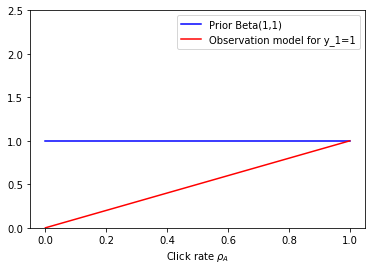

In [44]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, x, 'r-', label='Observation model for y_1=1')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

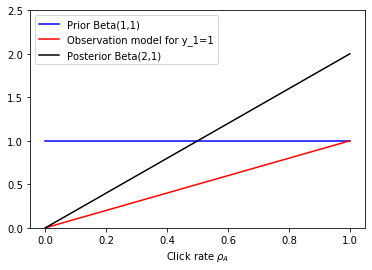

In [45]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, x, 'r-', label='Observation model for y_1=1')
plt.plot(x, scipy.stats.beta.pdf(x, 2, 1), 'k-', label='Posterior Beta(2,1)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

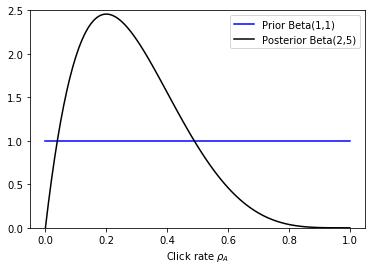

In [46]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, scipy.stats.beta.pdf(x, 2, 5), 'k-', label='Posterior Beta(2,5)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 3.1 Thompson sampling

When $t+1$th visitor comes, which ad, $A$ or $B$, to serve?

 * Want to exploit: gather as much clicks as possible.
 * Need to explore: learn about click rates for $A$ and $B$.
 
Thompson sampling is a simple algorithm navigating this trade-off:

 1. Sample a value for $\hat{\rho}_A$ and for $\hat{\rho}_B$ from $p(\rho_A \mid \mathcal{D}_t)$ and $p(\rho_B \mid \mathcal{D}_t)$.
 2. Show $A$ if $\hat{\rho}_A > \hat{\rho}_B$ and $B$ otherwise.
 
We then observe whether the visitor clicked the ad or not and update our posterior distributions and continue to next iteration.

## Example 
*How does Thompson sampling navigate exploration-exploitation trade-off?*

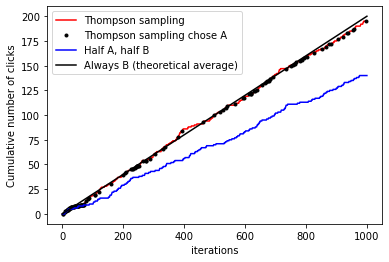

In [47]:

rho_A_true = 0.1; rho_B_true = 0.2 # simulated visitor click rates
alpha = 1; beta = 1 # prior parameters
n_A1 = 0; n_A0 = 0; n_B1 = 0; n_B0 = 0 # numbers of clicks/no-clicks
T = 1000 # number of iterations
clicks = np.zeros(T); A_or_B = np.zeros(T)

for t in range(T):
    # Thompson sampling
    rho_A = np.random.beta(alpha + n_A1, beta + n_A0)
    rho_B = np.random.beta(alpha + n_B1, beta + n_B0)
    if rho_A > rho_B: # which ad to show
        y_t = np.random.binomial(1, rho_A_true) # simul. click
        n_A1 += y_t; n_A0 += 1 - y_t; # update posterior of A
    else:
        y_t = np.random.binomial(1, rho_B_true) # simul. click
        n_B1 += y_t; n_B0 += 1 - y_t; # update posterior of B
    # collect statistics
    clicks[t] = y_t; A_or_B[t] = rho_A > rho_B
    
# instead of Thompson sampling, allocate same numbers to A and B
clicks_half = np.zeros(T)

for t in range(T):
    if t % 2 == 0:
        y_t = np.random.binomial(1, rho_A_true)
    else:
        y_t = np.random.binomial(1, rho_B_true)
    clicks_half[t] = y_t
    
plt.figure()
plt.plot(range(1,T+1), np.cumsum(clicks), 'r-', label='Thompson sampling')
plt.plot(np.array(range(1,T+1))[A_or_B==1], np.cumsum(clicks)[A_or_B==1], 'k.', label='Thompson sampling chose A')
plt.plot(range(1,T+1), np.cumsum(clicks_half), 'b-', label='Half A, half B')
plt.plot(range(1,T+1), np.array(range(1,T+1)) * rho_B_true, 'k-', label='Always B (theoretical average)')
plt.xlabel('iterations')
plt.ylabel('Cumulative number of clicks')
plt.legend(loc=2)
plt.show()

Other bandit solutions: https://en.wikipedia.org/wiki/Multi-armed_bandit#Optimal_solutions

# 4. Bayesian Optimization

<div class="center">
<img src="imgs/bayes_optimization.png" style="width: 100%" />
</div>

## Task

Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

Want to find the minimum with small number of evaluations of $f$.

 1. **Construct a tractable statistical surrogate model of $f$.**
 2. Turn the optimization problem into a sequence of easier problems.
 
 


## 4.1 Surrogate models

"A **surrogate model** is an engineering method used when an outcome of interest cannot be easily directly measured, so a model of the outcome is used instead." (Wikipedia)
 
Let $g(x)$ be our **surrogate model** of $f$.

 * $g$ should be able to capture important aspects of $f$ from small number of evaluations.
 * Need to be able to update $g$ when we acquire new evaluations of $f$: $g$ should get better and better as a model of $f$.
 * $g$ should be fast to evaluate and to update.
 * $g$ needs to cope with noise.
 * Need to be able to quantify uncertainty in $g$ (navigating exploration-exploitation tradeoff).

### Gaussian processes

Gaussian process (GP) regression models are commonly used surrogate models used in BO. This is because of its capacity to approximate a large subset of model fit surfaces that are encountered in practice. GP models are also able to model the stochasticity of model fit, thus allowing a principled estimation of its mean and variance everywhere in the parameter search space.

 * Gaussian processes provide a probability distribution over functions.
 * Extends (and uses properties of) the multivariate normal distribution $\Rightarrow$ computationally tractable.
 * Prior information about the type or behaviour of the modelled function can be included in the *covariance function* and its parameters.
 
 * Alternatives: random forests, Bayesian neural networks.
 
<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Open the [Interactive demo app](http://www.infinitecuriosity.org/vizgp/).</div>
</p>
<div id="gp-outer"></div>


## 4.2 Turn the optimization problem into a sequence of easier problems

Consider having evaluated $f$ at points $x_1, \ldots, x_{t-1}$ and having constructed $p(g \mid \mathcal{D}_{t-1})$.

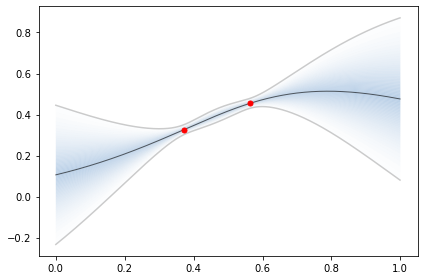

In [48]:
import GPy; import GPyOpt

def f_u(x):
    return x**2 + 0.1 + 0.1 * np.random.randn()
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]
myBopt = GPyOpt.methods.BayesianOptimization(
    f=f_u, domain=bounds, acquisition_type='EI',
    exact_feval = False, initial_design_numdata=2, normalize_Y=False)
max_iter = 0; max_time = 60; eps = 10e-6
#max_iter = 5; max_time = 60; eps = 10e-1

myBopt.run_optimization(max_iter, eps)
myBopt._update_model()
#myBopt.plot_acquisition()
#myBopt.model.model.plot([0.0,1.0])
model = myBopt.model.model

x_grid = np.arange(0, 1, 0.001)
x_grid = x_grid.reshape(len(x_grid),1)
m, v = model.predict(x_grid)

model.plot_density([0,1], alpha=.5)

plt.plot(x_grid, m, 'k-',lw=1,alpha = 0.6)
plt.plot(x_grid, m-1.96*np.sqrt(v), 'k-', alpha = 0.2)
plt.plot(x_grid, m+1.96*np.sqrt(v), 'k-', alpha=0.2)

Xdata, Ydata = myBopt.get_evaluations()

plt.plot(Xdata, Ydata, 'r.', markersize=10)

plt.show()

How to choose the next $x$ to evaluate $f$ at?

**What would you do?**

Consider having evaluated $f$ at points $x_1, \ldots, x_{t-1}$ and having constructed $p(g \mid \mathcal{D}_{t-1})$:

<Figure size 432x288 with 0 Axes>

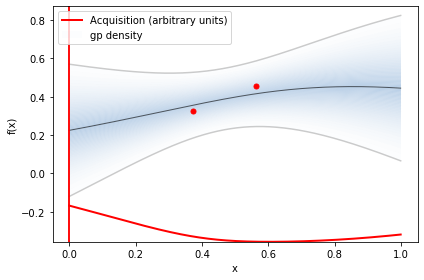

In [49]:
plt.figure()
myBopt.plot_acquisition()

---- 
# 5. Acquisition functions 
How to choose the next $x$ to evaluate $f$ at?

**Guided exploration** using $p(g \mid \mathcal{D}_{t-1})$:

 * Trade off exploration (reducing uncertainty) and exploitation (sampling near likely places of optima).
 * Formulated by maximizing an acquisition function $\alpha(x; \mathcal{D}_{t-1})$.
 
$$x_{t} = \argmax_x \alpha(x; \mathcal{D}_{t-1})$$

**Thompson sampling** acquisition function:

 * $\alpha(x; \mathcal{D}_{t-1}) = \hat{g}(x)$, where $\hat{g}(x)$ is a sample from $p(g \mid \mathcal{D}_{t-1})$.

**Expected improvement** acquisition function:

 * Currently best value $y^* = \max_{s \in \{1,\ldots,t-1\}} y_s$.
 * Improvement function provides utility of $x$ given $g$: $I(x, g) = (g(x) - y^*) I(g(x) > y^*)$.
 * Expected improvement: $\alpha_{EI}(x; \mathcal{D}_t) = \E_g[I(x, g)]$.

Many others also exists.

## Bayesian Optimization Recipe

**Goal**: Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**Key ideas**

 1. Construct a tractable statistical surrogate model of $f$.
 2. Turn the optimization problem into a sequence of easier problems.

**Algorithm**

 1. Initialize dataset $\mathcal{D}_0$, surrogate model $p(g \mid \mathcal{D}_0)$; choose acquisition function $\alpha(\cdot)$.
 2. Loop for $t = 1,2,\ldots,T$:
      1. Select next evaluation point: $x_{t} = \argmax \alpha(x; \mathcal{D}_{t-1})$.
      2. Evaluate $f(x_{t})$ to obtain $y_{t}$.
      3. Update dataset $\mathcal{D}_{t} = \{\mathcal{D}_{t-1},(x_t, y_t)\}$.
      4. Update surrogate model $p(g \mid \mathcal{D}_t)$.
 3. Report the found optimum.
 

## GPyOpt

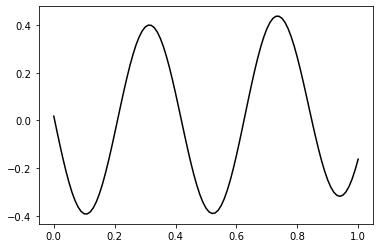

In [50]:
def f_u(x):
    return 0.2 * (x - 0.3)**2 - 0.4 * np.sin(15.0 * x)

plt.figure(); xx = np.linspace(0, 1, 101)
plt.plot(xx, f_u(xx), 'k-'); plt.show()

In [51]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]
myBopt = GPyOpt.methods.BayesianOptimization(
    f=f_u, domain=bounds,        # Function and domain                 
    acquisition_type='EI',       # Expected improvement
    exact_feval=True,            # Noiseless function evaluations
    eps=1e-6,
    normalize_Y=False,           # (for clearer visualization)
    initial_design_numdata=2)    # (for clearer visualization)

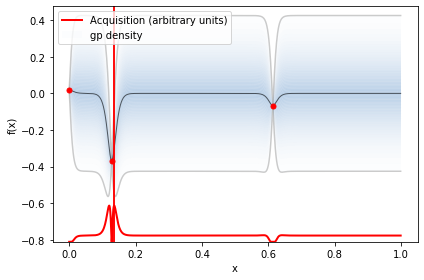

In [52]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

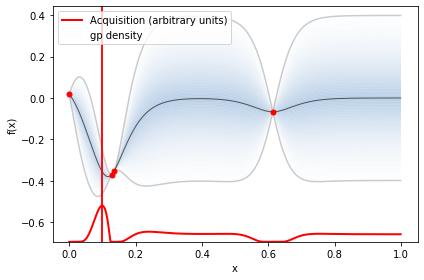

In [53]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

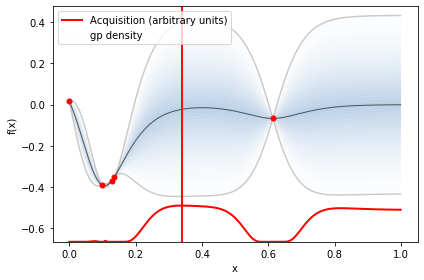

In [54]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

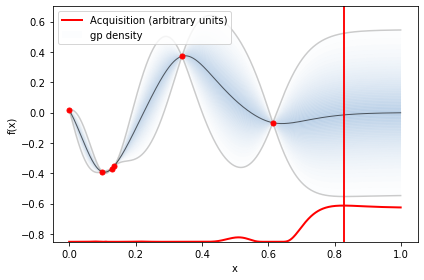

In [55]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

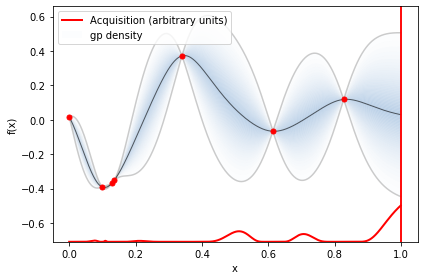

In [56]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

## Does it work?

 * Theoretical guarantees (regret bounds) exists under some conditions.
 * ''There is still a wide gap between theory and practice.'' - Shahriari et al.

''[...]the careful choice of statistical model is often far more important than the choice of acquisition function heuristic.'' - Shahriari et al.

**Some limitations**

 * Difficult for high-dimensional spaces.
 * Can spend a lot of time on the edges of the space (Siivola et al., MLSP 2018).
 * Computation complexity of inference in Gaussian processes scales as $O(N^3)$, where $N$ is the number of observations (sparse GPs/inducing point approximations can be used; or other types of models).
 * Optimizing hyperparameters (controlling the behaviour of the surrogate) can be challenging.

---

# 6. Application example

Two types of rather direct human-in-the-loop applications:
 * Human provides explicit feedback at $x$, the value $f(x)$.
 * Human provides implicit feedback at $x$, for example, $f(x)$ is a completion time of a task with parameters $x$.

## Animation design

Find parameters for generating a procedural fluid animation:
* velocity, radius and magnitude of the (possibly multiple) vortex rings,
* length scale and magnitude of the curl noise,
* relative strengths of vortex rings and curl noise.

User can easily tell which animations look good: ''the psychoperceptual process underlying judgment - how well a realization fits what the user has in mind''.

<div class="center">
<img src="imgs/anim.png" style="width: 50%" />
</div>

*Eric Brochu, Tyson Brochu, Nando de Freitas: A Bayesian Interactive Optimization Approach to Procedural Animation Design, Eurographics/ACM SIGGRAPH Symposium on Computer Animation (2010).*

### User interface
<div class="center">
<img src="imgs/ui.png" style="width: 79%" />
</div>

### Algorithm
<div class="center">
<img src="imgs/bo_alg.png" style="width: 79%" />
</div>

### User study
 * Obtained improved results compared to novice and expert users setting parameters manually.
 * Tailored the Bayesian optimization approach to make it work:
      1. preferential feedbacks,
      2. transfer information over multiple sessions,
      3. com-bined manual parameter tuning and Bayesian optimization.
      

---
# In-class exercise: Eliciting color preferences

<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Below is a script that implements the color preference elicitation problem. It asks 8 questions. Can you figure out how to improve it?  
<br>
<b>Tip:</b> Can you improve the acquisition function? Three things to try are: 
‘EI’, expected improvement;
‘MPI’, maximum probability of improvement; and
‘LCB’, GP-Lower confidence bound. 
[Manual page](https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html)
</div>
</p>




[[0.04280539 0.71558447 0.8590085 ]]


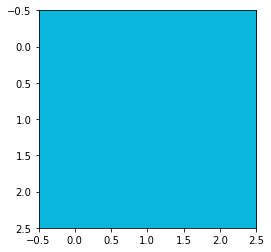

Grade? (0 to 5) 4
[[0.90662936 0.17524603 0.19012151]]


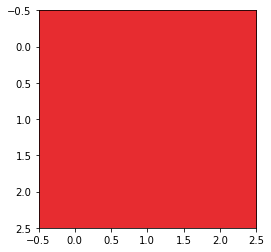

Grade? (0 to 5) 0
[[0.04280538 0.71558448 0.85900851]]


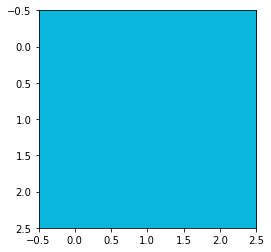

Grade? (0 to 5) 4
[[0.04288089 0.71660892 0.85819104]]


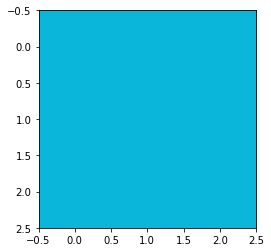

Grade? (0 to 5) 4
[[0.00363959 0.74306774 0.88722226]]


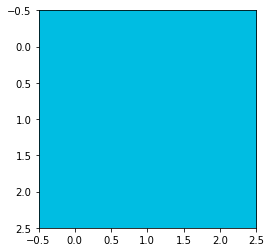

Grade? (0 to 5) 5
[[0.         0.74550457 0.88996125]]


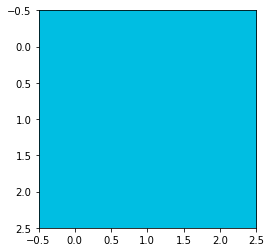

Grade? (0 to 5) 5
[[0.00628976 0.74651129 0.89270422]]


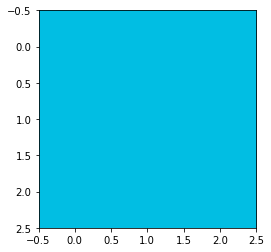

Grade? (0 to 5) 5
[[0.00254472 0.7402657  0.89377069]]


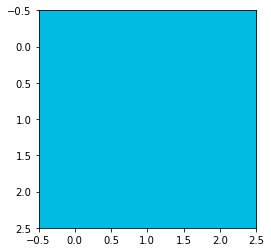

Grade? (0 to 5) 5
[0.55922784 0.64048923 0.42694683]


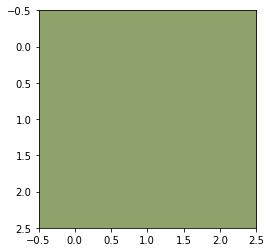

Grade? (0 to 5) 3
[0.88539918 0.8222349  0.09762061]


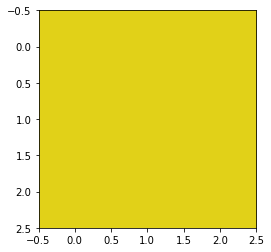

Grade? (0 to 5) 1
[0.20760577 0.9565966  0.7495561 ]


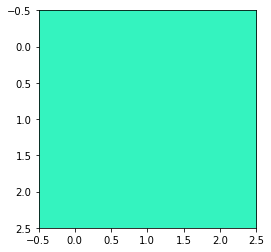

Grade? (0 to 5) 3
[0.78708212 0.60183808 0.17309091]


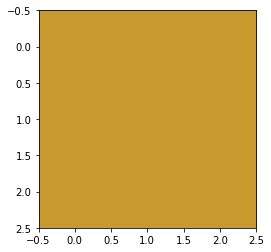

Grade? (0 to 5) 1
[0.61891619 0.19304465 0.00854869]


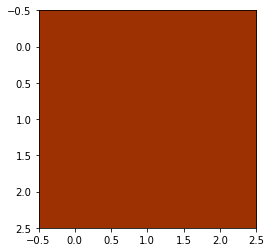

Grade? (0 to 5) 1
[0.3196337  0.89982463 0.01250095]


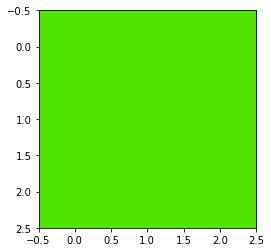

Grade? (0 to 5) 3
[0.8251792  0.07614509 0.76970126]


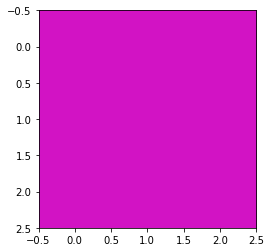

Grade? (0 to 5) 1
[0.27292638 0.23916668 0.89137577]


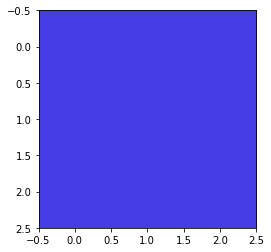

Grade? (0 to 5) 4


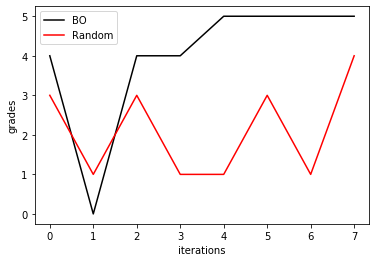

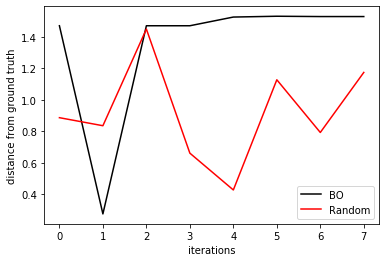

In [26]:
def f_u(x):
    plt.figure(1)
    print(x)
    im = x.reshape(1, 1, 3).repeat(3, axis=0).repeat(3, axis=1)
    plt.imshow(im)
    plt.show(block=False)
    while True:
        res = input('Grade? (0 to 5) ')
        if res in ['0', '1', '2', '3', '4', '5']:
            res = int(res)
            plt.close(1)
            return res


def run_bo(max_iter):
    bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 1)},
              {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)},
              {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)}]
    myBopt = GPyOpt.methods.BayesianOptimization(
        f=f_u, domain=bounds,
        acquisition_type='MPI',
        exact_feval=False,
        eps=1e-6,
        normalize_Y=False,
        initial_design_numdata=2,
        maximize=True)
    myBopt.run_optimization(max_iter=max_iter - 2)

    return myBopt


def run_random(max_iter):
    xs = np.zeros((max_iter, 3))
    ys = np.zeros((max_iter,))

    for i in range(max_iter):
        xs[i, :] = np.random.rand(3)

        ys[i] = f_u(xs[i, :])

    return xs, ys


if __name__ == "__main__":
    n_iter = 8
    # run BO
    bo = run_bo(n_iter)
    # run random for comparison
    ra = run_random(n_iter)

    bo_xs, bo_ys = bo.get_evaluations()
    ra_xs, ra_ys = ra

    # one can investigate these to see how good colors were found and compare
    # to a ground truth color

    plt.plot(-bo_ys, 'k-', label='BO')
    plt.plot(ra_ys, 'r-', label='Random')
    plt.xlabel('iterations')
    plt.ylabel('grades')
    plt.legend()
    plt.show()

    # let's say ground truth color was red
    x_gt = np.array([1.0, 0.0, 0.0])

    plt.plot(np.sqrt(np.sum((bo_xs - x_gt)**2, 1)), 'k-', label='BO')
    plt.plot(np.sqrt(np.sum((ra_xs - x_gt)**2, 1)), 'r-', label='Random')
    plt.xlabel('iterations')
    plt.ylabel('distance from ground truth')
    plt.legend()
    plt.show()



---

# 6. Conclusion 

## Summary
Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

 * $f$ is a black-box that we can only evaluate point-wise, 
 * $f$ can be multi-modal,
 * $f$ is slow or expensive to evaluate,
 * evaluations of $f$ are noisy,
 * $f$ has no gradients available (can be used if available).

**Key ideas**

 1. Construct a tractable statistical surrogate model of $f$, with proper uncertainty quantification.
 2. Turn the optimization problem into a sequence of easier problems, navigating the exploration-exploitation tradeoff.


**Wide range of applications**. Relevant for HCI and human-in-the-loop modelling.

Many **software implementations** (e.g., GPyOpt) exists. Relatively easy to start using.

## Readings
 * <a href="https://ieeexplore.ieee.org/document/7352306">Shahriari et al., **Taking the Human Out of the Loop: A Review of Bayesian Optimization**, Proceedings of the IEEE, 2016.</a>
 * <a href="http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb">Cam Davidson-Pilon, **Chapter 1: Introduction to Bayesian Methods from Bayesian Methods for Hackers**.<a/>
 * <a href="http://www.gaussianprocess.org/gpml/">Rasmussen, Williams, **Gaussian Processes for Machine Learning**, MIT Press, 2016.</a>
 * <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt, Python package for Bayesian optimization.</a>
 * <a href="http://www.tmpl.fi/gp/">Interactive Gaussian process regression demo.</a>
 * <a href="https://dl.acm.org/citation.cfm?id=1921443">Brochu et al., **A Bayesian Interactive Optimization Approach to Procedural Animation Design**, Eurographics/ACM SIGGRAPH Symposium on Computer Animation, 2010.</a>.
 * <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184054">Kim et al., **Human-in-the-loop Bayesian optimization of wearable device parameters**, PLOS ONE, 2017.</a>
 * <a href="https://dl.acm.org/citation.cfm?doid=3025453.3025576">Kangasraasio et al., **Inferring Cognitive Models from Data using Approximate Bayesian Computation**, CHI 2017.</a>
 * <a href="https://arxiv.org/abs/1704.00963">Siivola et al., **Correcting boundary over-exploration deficiencies in Bayesian optimization with virtual derivative sign observations**, MLSP 2018.</a>